# <center>Wskaźnik giełdowy MACD</center>
## <center>Wiktoria Lewicka 184915</center>

Celem projektu jest ocena przydatności MACD w analizie technicznej na podstawie działania algorytmu symulującego kupno i sprzedaż akcji Tesli według wskaźnika MACD.

Dane użyte w projekcie zostały pobrane ze strony https://finance.yahoo.com/quote/TSLA/history?p=TSLA w dniu 28.03.2022.

Import wszystkich niezbędnych modułow:
pandas - do pobrania i przetwarzania danych z pliku .csv
matplotlib - do rysowania wykresów

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Pobranie danych z pliku .csv:

In [2]:
df = pd.read_csv('C:\\Users\\vip\\Documents\\MACDprojekt\\TSLA.csv', nrows=1000)

Funkcja pomocnicza do obliczania EMA (wykładniczej średniej kroczącej), wykonująca operacje na seriach danych po N elementów.
Wykładnicza średnia krocząca dla jednego okresu (1 serii danych) obliczana jest według następującego
wzoru:
$$\mathrm{EMA}_{n}=\frac{\mathrm{p}_{0}+(1-\alpha)\mathrm{p}_{1}+(1-\alpha)^2\mathrm{p}_{2}+...+(1-\alpha)^N\mathrm{p}_{N}}{1+(1-\alpha)+(1-\alpha)^2+...+(1-\alpha)^N}$$


In [3]:
def ema_comp(data):
    n = data.size
    alfa = 2.0 / (n + 1.0)
    meter = 0.0
    denominator = 0.0

    for index, value in data.items():
        meter += pow((1.0 - alfa), index) * value
        denominator += pow((1.0 - alfa), index)

    return meter / denominator

Funkcja obliczająca EMA, jako argumenty przyjmuje:
- n: okres czasu w dniach z jakiego ma być kolejno liczona średnia krocząca
- data: seria danych, na których mają być wykonywane obliczenia

In [4]:
def ema(n, data):
    em = data.rolling(window=n, min_periods=n).apply(ema_comp)
    return em;

Obliczenie EMA 26 i 12 okresową:

In [5]:
ema12 = ema(12, df["Close"])
ema26 = ema(26, df["Close"])

Obliczenie MACD i Signal:

In [6]:
df["MACD"] = ema12 - ema26
df["Signal"] = ema(9, df["MACD"])

Wypisanie obliczonych danych

In [7]:
print(df[["Date", "Close", "MACD", "Signal"]])

           Date       Close        MACD     Signal
0    2017-03-28   55.490002         NaN        NaN
1    2017-03-29   55.476002         NaN        NaN
2    2017-03-30   55.584000         NaN        NaN
3    2017-03-31   55.660000         NaN        NaN
4    2017-04-03   59.703999         NaN        NaN
..          ...         ...         ...        ...
995  2021-03-11  699.599976 -104.004313 -73.241642
996  2021-03-12  693.729980 -109.027301 -80.021451
997  2021-03-15  707.940002 -103.393028 -86.338608
998  2021-03-16  676.880005  -96.390754 -92.065888
999  2021-03-17  701.809998  -96.615347 -97.905543

[1000 rows x 4 columns]


Narysowanie wykresów Signal i MACD:

Text(0, 0.5, 'wartość wskaźnika')

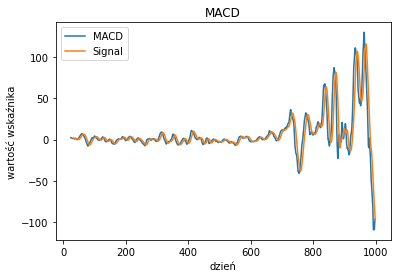

In [8]:
ax = df[['MACD','Signal']].plot(title='MACD')
ax.set_xlabel("dzień")
ax.set_ylabel("wartość wskaźnika")

Text(0, 0.5, 'wartość akcji')

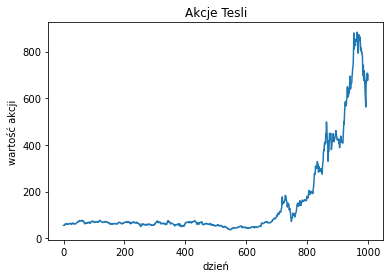

In [9]:
ax = df['Close'].plot(title='Akcje Tesli')
ax.set_xlabel("dzień")
ax.set_ylabel("wartość akcji")

**Wnioski na podstawie otrzymanych wykresów:** linie MACD i Signal przecinają się w okolicach maksymalnego wzrostu lub spadku wartości akcji. Oznacza to, że można wykorzystać wskaźnik MACD w celu zwiększenia przychodu z kupna i sprzedaży akcji.

## Algorytm kupujący i sprzedający akcje
Poniższy algorytm kupuje n akcji, gdy MACD przecina SIGNAL od dołu i sprzedaje 2*n akcji, gdy MACD przecina SIGNAL od góry.
Celem algorytmu jest powiększenie wirtualnego majątku.

Poprzez porównianie bieżących i poprzednich wartości Signal i MACD algorytm ten decyduje, czy opłaca się sprzedać albo kupić akcje:
- jeśli nastąpi dobry moment na kupno, kupowane jest n akcji
- jeśli jest dobry moment na sprzedaż, sprzedawane jest n*2 akcji
- jeśli nastąpił dobry moment na sprzedaż, ale liczba akcji jest mniejsza niż n*2, sprzedawane są wszystkie posiadane akcje
- jeśli zabraknie pieniędzy na zakup n akcji, zakup jest pomijany

Pieniądze w budżecie nie tracą na wartości (w tym projekcie), dlatego algorytm wydaje mniej pieniędzy i sprzedaje więcej akcji. W ten sposób przychód nie będzie zbyt szybko rosnąć, jednak również w przypadku pomyłki algorytmu, straty nie powinny zrujnować budżetu.

In [10]:
def sell_buy(budget, actions, n, df):
    prev_mac = df.iloc[0]["MACD"]
    prev_signal = df.iloc[0]["Signal"]
    
    sell_counter = 0;
    buy_counter = 0;

    print("Stan początkowy")
    print("Saldo: ", budget, " wartosc akcji: ", round(actions * df.loc[0]["Close"]),
          " Razem: ", round(budget + actions * df.loc[0]["Close"]))

    df = df.reset_index()
    for index, row in df.iterrows():
        if row["Signal"] > row["MACD"] and prev_signal < prev_mac:
            if n * row["Close"] <= budget:
                budget -= n * row["Close"]
                actions += n
                buy_counter += n

        if row["Signal"] < row["MACD"] and prev_signal > prev_mac:
            if actions >= n * 2:
                actions -= n * 2
                budget += n * 2 * row["Close"]
                sell_counter += n * 2
            else:
                budget += actions * row["Close"]
                sell_counter += actions
                actions = 0

        prev_mac = row['MACD']
        prev_signal = row['Signal']

    print("Stan koncowy")
    print("Saldo: ", round(budget), " wartosc akcji: ", round(actions * df.loc[0]["Close"]),
          " Razem: ", round(budget + actions * df.iloc[-1]["Close"]))
    print("Liczba sprzedanych akcji: ", sell_counter)
    print("Liczba kupionych akcji: ", buy_counter)

### Test 1
#### Czy algorytm potrafi zarabiać?

**Test algorytmu dla wartości:**
- budżet początkowy: 1000
- początowa liczba akcji: 0
- liczba kupowanych akcji podczas spadku: 1
- liczba sprzedawanych akcji podczas wzrostu: 1*2 = 2

In [11]:
sell_buy(1000, 0, 1, df)

Stan początkowy
Saldo:  1000  wartosc akcji:  0  Razem:  1000
Stan koncowy
Saldo:  1298  wartosc akcji:  0  Razem:  1298
Liczba sprzedanych akcji:  36
Liczba kupionych akcji:  36


**Test algorytmu dla wartości:**
- budżet początkowy: 100000
- początowa liczba akcji: 500
- liczba kupowanych akcji podczas spadku: 50
- liczba sprzedawanych akcji podczas wzrostu: 50*2 = 100

In [12]:
sell_buy(100000, 500, 50, df)

Stan początkowy
Saldo:  100000  wartosc akcji:  27745  Razem:  127745
Stan koncowy
Saldo:  148767  wartosc akcji:  0  Razem:  148767
Liczba sprzedanych akcji:  2300
Liczba kupionych akcji:  1800


**Wnioski:** <br>
Algorytmowi udało się przynieść zysk w powyższych przypadkach, można więc stwierdzić, że algorytm potrafi zarabiać.

### Test 2
#### Czy algorytm zarobi więcej kupując i sprzedając akcje, czy większy zysk przyniesie tylko trzymanie akcji bez sprzedaży i kupna?

**Test algorytmu dla wartości:**
- budżet początkowy: 0
- początowa liczba akcji: 500
- liczba kupowanych akcji podczas spadku: 50
- liczba sprzedawanych akcji podczas wzrostu: 50*2 = 100

In [13]:
sell_buy(0, 500, 50, df)

Stan początkowy
Saldo:  0  wartosc akcji:  27745  Razem:  27745
Stan koncowy
Saldo:  48767  wartosc akcji:  0  Razem:  48767
Liczba sprzedanych akcji:  2300
Liczba kupionych akcji:  1800


**Test algorytmu dla wartości:**
- budżet początkowy: 0
- początowa liczba akcji: 500
- liczba kupowanych akcji podczas spadku: 0
- liczba sprzedawanych akcji podczas wzrostu: 0*2 = 0

In [14]:
sell_buy(0, 500, 0, df)

Stan początkowy
Saldo:  0  wartosc akcji:  27745  Razem:  27745
Stan koncowy
Saldo:  0  wartosc akcji:  27745  Razem:  350905
Liczba sprzedanych akcji:  0
Liczba kupionych akcji:  0


**Wnioski**<br>
Większy zysk przyniósł obrót akcjami przez algorytm (aktualna wartość majątku: 48767) niż przetrzymanie akcji (aktualna wartość majątku: 350905). W obydwu przypadkach nie ma żadnych strat (wartość początkowa majątku: 27745)

## Ogólne wnioski
Wskaźnik MACD może być przydatny przy podejmowaniu decyzji o kupnie i sprzedaży akcji. Dzięki temu wskaźnikowi szanse na zarobek będą większe. Jest to jeden z wielu czynników, które warto wziąć pod uwagę decydując się na taki rodzaj inwestycji.